# Results: Gas - Riser 


In [22]:
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import datetime as dttm
from itertools import islice
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.field_names import FieldName
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, RepeatVector, LSTM, TimeDistributed, Activation
from tensorflow.keras.preprocessing import sequence
from tcn import TCN
from tensorflow import keras
import tensorflow as tf
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML/src')
from preprocessing import read_data_slugging
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML')
from main import model_init, model_train, model_predict 

### Reading the data

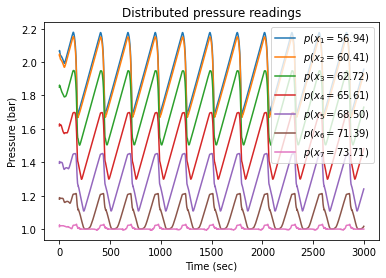

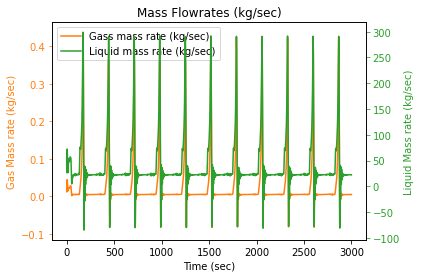

In [4]:
df,data_slugging,headers, _= read_data_slugging('riser_pq_uni.csv', plot_data=True)
## prophet training and testing
train_mult = df.iloc[:2806]
test_mult = df.iloc[2806:len(df)]
## TCN training and testing 
x_uni, y_uni = univariate_data(np.array(dt_gas_riser), 0, 2805, 300, 5)
x_testing_uni, y_testing_uni = univariate_data(np.array(dt_gas_riser), 2500, 2999, 300, 5)


#### Some helpful functions:

In [6]:
def generate_samples(data, features, Nts, step, length, shift):

    X = np.zeros((Nts, length, len(features)))
    tX = np.zeros((Nts, length))
    for i in range(Nts):
        X[i] = data[i*step+shift : i*step+shift+length, features]
        tX[i] = data[i*step+shift : i*step+shift+length, 0]

    return X, tX

def run(data, inp_features, outp_features, Nseq, Nts, step, inp, outp, model_name):

    N = data.shape[0]  # Overall sequence length

    # Fix random seed for reproducibility
    import os
    import random
#     import tensorflow.compat.v1 as tf
#     tf.disable_v2_behavior()
    import tensorflow as tf
    import tensorflow.keras
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(1)
    random.seed(1)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#     session_conf = tensorflow.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8)
    tf.compat.v1.set_random_seed(1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

    # Model name to save the weights
    ilist = ['%d' % i for i in inp_features]
    ilist = ''.join(ilist)
    olist = ['%d' % i for i in outp_features]
    olist = ''.join(olist)
    print(ilist)
    print(olist)
    mname = model_name + '_i' + ilist + '_o' + olist

    model_fit = True    # Fit the model, save it weights to mname.h5, save the convergence history to mname.svg, and run predictions
    #model_fit = False   # Load the previously saved mname.h5 and run predictions

    pyplot.close('all')

    X, tX = generate_samples(data, inp_features, Nts, step, inp, 0)
    Y, tY = generate_samples(data, outp_features, Nts, step, outp, inp)

    #visualize(X, tX, Y, tY)

    if model_name == 'LSTM':

        # Many-to-many with steps_before = steps_after
        model = Sequential()
        model.add(LSTM(units=10, input_shape=(inp, len(inp_features)), return_sequences=True))
        model.add(LSTM(units=10, return_sequences=True))
        model.add(LSTM(units=10, return_sequences=True))
        model.add(TimeDistributed(Dense(len(outp_features))))
        model.add(Activation('linear'))
        # model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
        model.compile(loss='mean_squared_error', optimizer='adam')
        print(model.summary())

        # Ironbell #2 & #3
        history = model.fit(X, Y, batch_size=1, epochs=10, validation_split=0.05)

    elif model_name == 'LSTM_Encoder':

        # Many-to-many with steps_before <> steps_after
        model = Sequential()
        model.add(LSTM(units=10, input_shape=(None, len(inp_features)), return_sequences=False))
        model.add(keras.layers.RepeatVector(outp))
        model.add(LSTM(units=10, return_sequences=True))
        model.add(LSTM(units=10, return_sequences=True))
        model.add(TimeDistributed(Dense(len(outp_features))))
        model.add(keras.layers.Activation('linear'))
        #model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
        model.compile(loss='mean_squared_error', optimizer='adam')
        print(model.summary())

        history = model.fit(X, Y, batch_size=1, epochs=10, validation_split=0.05)

    elif model_name == 'FF':  # Feedforward NN

        if len(inp_features) != 1 or len(outp_features) != 1:
            print('Feedforward NN is only defined for a single feature.. Exiting..')
            return

        X = X.reshape(len(X), inp)
        Y = Y.reshape(len(Y), outp)

        model = Sequential()
        model.add(Dense(10, input_shape=(inp,)))
        model.add(Dense(10))
        model.add(Dense(10))
        model.add(Dense(outp))
        model.add(Activation('linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        print(model.summary())

        history = model.fit(X, Y, batch_size=1, epochs=10, validation_split=0.05)

    else:
        print('Model not defined.. Exiting..')
        return
    # Save the model
    model.save(mname + '.h5')

    # Plotting the convergence history
    pyplot.figure(3)
    pyplot.semilogy(history.history['loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.show(block=False)

    # Save the convergence history
    df = pd.DataFrame(history.history['loss'])
    df.index.name = 'Epoch'
    nametmp = mname + '_convergence.csv'
    df.to_csv(nametmp)

    #pyplot.savefig(mname + '_convergence.svg')
    pyplot.savefig(mname + '_convergence.pdf')


    # Generating the test sequences covering all data, so that the output sequences are not-overlapping
    step = outp
    Ns = int((N-Nseq)/step + 1)
    # Renamed X, tX etc to avoid a bug in PyCharm
    XX, tXX = generate_samples(data, inp_features, Ns, step, inp, 0)
    YY, tYY = generate_samples(data, outp_features, Ns, step, outp, inp)

    if model_name == 'FF':  # Feedforward NN
        XX = XX.reshape(len(XX), inp)

    # Prediction on all data
    Ypred = model.predict(XX, verbose=0)



    pyplot.figure(1)
    for i in range(Ns):
        #pyplot.plot(tXX[i], XX[i], linewidth=3)
        pyplot.plot(tYY[i], YY[i], '+', linewidth=1)
        pyplot.plot(tYY[i], Ypred[i], 'o', linewidth=3)

    #pyplot.legend()
    pyplot.show(block=False)
    #pyplot.show()
    pyplot.savefig(mname + '.svg')
    pyplot.savefig(mname + '.pdf')
    pyplot.savefig(mname + '.png')

    print('Done..')


#### running the code:

In [23]:
input_features = [i for i in range(1, 7+1)]
outp_features = [9]
N = data_slugging.shape[0]
Ntr = int(0.5 * N)
Nseq = Ntr // 4 
pred_frac = 0.5  # Within a training sequence, fraction of data used for prediction
outp = max(1, int(pred_frac * Nseq))  # Number of timesteps in the output sequence
inp = Nseq - outp  
step = 1
Nts = int((Ntr - Nseq) / step + 1)
Ntr = Nseq + step * (Nts - 1) 
run(data_slugging, input_features, outp_features, Nseq, Nts, step, inp, outp, 'LSTM_Encoder')


1234567
9
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10)                720       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 187, 10)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 187, 10)           840       
_________________________________________________________________
lstm_9 (LSTM)                (None, 187, 10)           840       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 187, 1)            11        
_________________________________________________________________
activation_2 (Activation)    (None, 187, 1)            0         
Total params: 2,411
Trainable params: 2,411
Non-trainable params: 0
__________________________________________

KeyboardInterrupt: 